<a href="https://colab.research.google.com/github/luisjordana/Facial_Emotion_Detection/blob/main/Tensor_flow_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Human faces convey a rich set of implicit information essential for human interaction, with emotional cues being among the most important elements. As humans increasingly interact with computers, often through computer video cameras, there's a growing need for Artificial Intelligence to detect human emotions to enhance these interactions. For instance, during the pandemic, software was used to automatically detect the emotions of children in classrooms, aiding teachers in increasing engagement during sessions. Moreover, studies indicate that up to 55% of sentiment communication relies on implicit facial information. Not surprisingly, emotional facial recognition has been a relevant field in Artificial Intelligence for several years, leading to the development of various algorithms to detect emotions based on images, yet there remains room for improvement.

**The objectives:** The objective is to detect the four types of emotions (happy, sad, surprise, and neutral) conveyed in black and white images of human faces.

**The key questions:** What is the best deep learning architecture for classifying these images? Can we achieve better performance using transfer learning? Are certain types of emotions more difficult to classify for our algorithms than others?

**The problem formulation:** We aim to classify photos into four types of emotions: happy, sad, surprise, and neutral.


## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**



In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2

import zipfile

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential,  Model

from tensorflow.keras.layers import ELU, LeakyReLU, ReLU, RandomZoom,RandomFlip, Input, RandomRotation, Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, ReLU, GlobalAveragePooling2D

from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Regularization method to prevent the overfitting

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

from tensorflow.keras import backend

from tensorflow.keras import activations

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import random

import seaborn as sns
# Library for creating data paths
import os


In [ ]:
print(tf.__version__)

2.12.0


### **Let us load and unzip the data,we will also load our data sets into the three types, training, validation and test**

**Note:**
- When observing our test, train and validation sets, some photos are error photos. The error photos were deleted from their corresponding sets (except for the set we will use as a test set (the validation one)) and the folder was compresed again. We didn't modified any of the photos of this set because EDA should not be perform on the testing data.
- We have doubts on the use of the test split as it only contains 120 photos. On contrast the train split contains around 12000 photos. A normal validation split or test split will be of at least 10%, 1200, 10 times more than the 120 contained on the test split. Uing such a small validation split or test split will potentially lead to unrealiable results that are very dependant on the 30 photos each class has in that split. Therefore, the test photos were included into the folder containing the training split and the folder was compressed again. This means that we will use the validation set as our test set.

In [5]:
# Storing the path of the data file
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# Extract the zip file to be able to use it
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

**Remarks:** The following data loaders will be used. Such data loaders were two,one for the test data and one for the train and validation set. The test data only included a rescaling to make pixels be scale from 0 to 1. On the other hand the train data gen included a resclaing of the pixels (to scale them from 0 to 1), and data augmentation techniques. Such techniques were a brightness range (randomly changes the brightness of the image), horizontal flip, zoom_range (range 0% to 10%), Rotation range (range of 10º), and shear range (up to 30%). We did not apply any vertical flips because this will have alter the semantics of faces positioning the mouth in the top and the eyes in the bottom. The train data gen also includes a 20% split use to create the validation set.  

In [ ]:
train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

CATEGORIES = ["happy", "sad",'surprise', "neutral"]
IMG_SIZE = 48
BATCH_SIZE = 64


# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.2,1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.3,
    validation_split=0.2
)

# Create the test data generator with normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


## **Visualizing our Classes**

### **Happy**

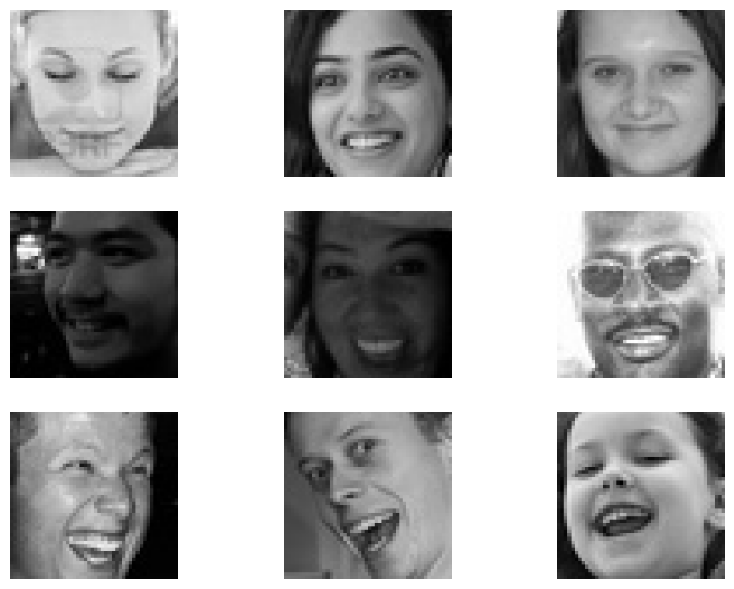

In [ ]:
DATADIR = 'Facial_emotion_images/train'                            # Path of to test data after unzipping
happy_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[0]}') ]
select_happy = np.random.choice(happy_imgs, 9, replace = False)

fig = plt.figure(figsize = (10, 10))

for i in range(9):
    ax = fig.add_subplot(4, 3, i + 1)

    fp = f'{DATADIR}/{CATEGORIES[0]}/{select_happy[i]}'

    fn = load_img(fp, target_size = (150, 150))

    plt.imshow(fn, cmap = 'Greys_r')

    plt.axis('off')

plt.show()

**Observations:** Common to all the displayed photos is a clear presence of smiles, often showcasing the upper teeth, and in some instances, all teeth are visible. However, some photos depict closed-mouth smiles. Additionally, there is a noticeable raising of the cheeks, exerting pressure on the sides of the eyes, which generally appear slightly closed. Among the happy faces, those displaying teeth appear to be the most distinctive cases.

### **Sad**

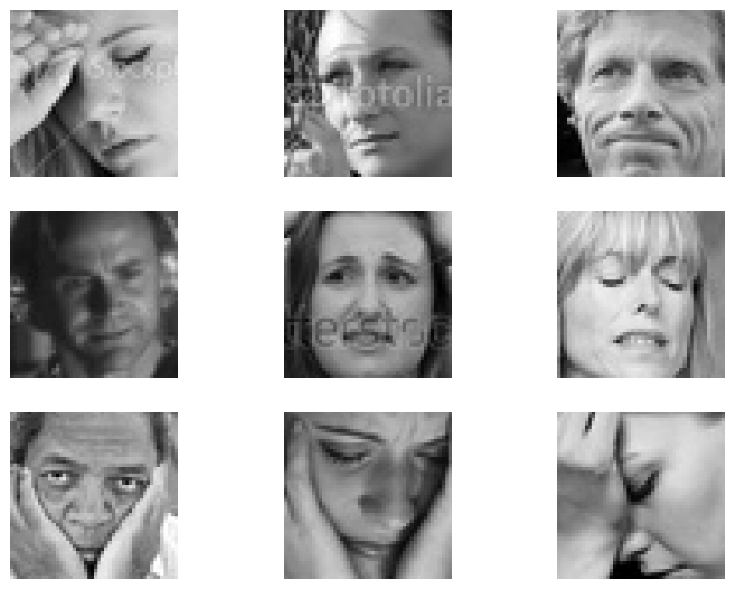

In [ ]:
sad_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[1]}') ]
select_sad = np.random.choice(sad_imgs, 9, replace = False)

fig = plt.figure(figsize = (10, 10))

for i in range(9):
    ax = fig.add_subplot(4, 3, i + 1)

    fp = f'{DATADIR}/{CATEGORIES[1]}/{select_sad[i]}'

    fn = load_img(fp, target_size = (150, 150))

    plt.imshow(fn, cmap = 'Greys_r')

    plt.axis('off')

plt.show()

**Observations:** In sad images, there is a noticeable downward movement of the corners of the lips, often accompanied by tense facial expressions. Additionally, hands are visible in some photos, often holding the sides of the face, indicating distress or despair. Tears are also present in some of the photos, further emphasizing the emotional state. This category exhibits a considerable variability, with a wide range of expressions conveying sadness.

### **Neutral**

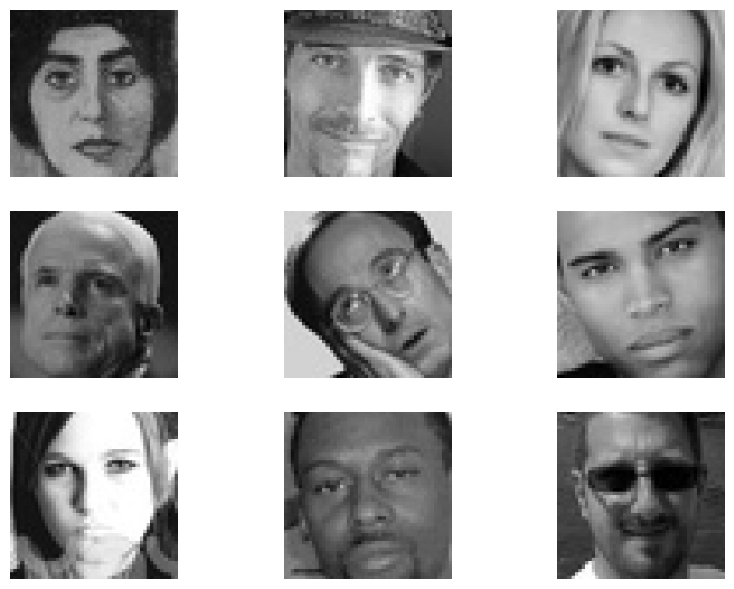

In [ ]:
neutral_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[3]}') ]
select_neutral = np.random.choice(neutral_imgs, 9, replace = False)

fig = plt.figure(figsize = (10, 10))

for i in range(9):
    ax = fig.add_subplot(4, 3, i + 1)

    fp = f'{DATADIR}/{CATEGORIES[3]}/{select_neutral[i]}'

    fn = load_img(fp, target_size = (150, 150))

    plt.imshow(fn, cmap = 'Greys_r')

    plt.axis('off')

plt.show()

**Observations:** Neutral faces typically exhibit an absence of overt emotions, with the lips maintaining a neutral position. However, some of the photos bear a resemblance to sad faces without tears, which could pose a potential challenge in classification. Moreover, there isn't a distinct characteristic that sets this class apart, potentially leading to difficulties in classification.

### **Surprised**

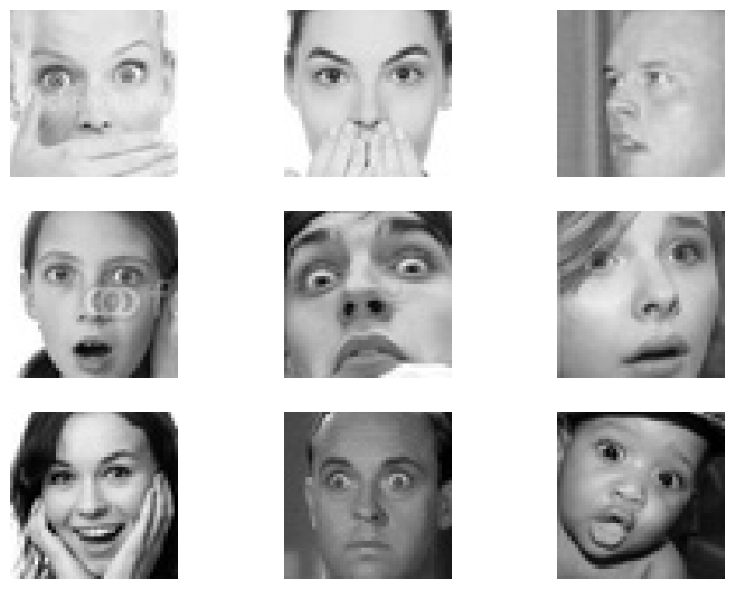

In [ ]:
surprise_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[2]}') ]
select_surprise = np.random.choice(surprise_imgs, 9, replace = False)

fig = plt.figure(figsize = (10, 10))

for i in range(9):
    ax = fig.add_subplot(4, 3, i + 1)

    fp = f'{DATADIR}/{CATEGORIES[2]}/{select_surprise[i]}'

    fn = load_img(fp, target_size = (150, 150))

    plt.imshow(fn, cmap = 'Greys_r')

    plt.axis('off')

plt.show()

**Observations:** Surprise faces are characterized by wide-open mouths and eyes, conveying a sense of astonishment. In some instances, hands may cover the mouths or sides of the faces, further emphasizing the surprise expression. This class, along with happy faces, exhibits more distinct and unique characteristics, which can aid the algorithm in correctly identifying the class.

## **Distribution of the classes for traning and test set**

In [ ]:
# Getting count of images in each folder within our training path
num_happy = len(os.listdir(train_dir + "/happy"))
print("Number of images in the class 'happy':   ", num_happy)

num_sad =  len(os.listdir(train_dir + "/sad"))
print("Number of images in the class 'sad':   ", num_sad)

num_neutral =  len(os.listdir(train_dir + "/neutral"))
print("Number of images in the class 'neutral':   ", num_neutral)

num_surprise =  len(os.listdir(train_dir + "/surprise"))
print("Number of images in the class 'surprise':   ", num_surprise)

Number of images in the class 'happy':    4004
Number of images in the class 'sad':    4009
Number of images in the class 'neutral':    4000
Number of images in the class 'surprise':    3198


**Observations**: The classes are more or less evenly distributed in the training set, with surprise having around 5% or 900 pictures fewer than the other categories. Despite this difference, we believe we are equipped to work with this dataset without artificially increasing the number of photos for any class.

However, the distribution is slightly different for the test set, where the category happy is overrepresented compared to the other three. Additionally, surprise is even lower in this set compared to the training set. While this difference may be important when interpreting results in the test set, we believe it is not significant enough to distort our findings as long as we account for this variation in proportion.

## **Simple Model Building**

CNN should naturally perform better than ANN. The models overfit so to fight it we will use dropout 20%. We tried also Batch Normalization and a 3 types of optimizers, SVG, RMSprop and Adam optimizer. Batch Normalization didn't help with overfitting. Also the optimizers SVG and RMSprop performed poorly compared to Adam optimizer. RMSprop took more epochs than Adam to arrived to the same result without leading to less overfitting, while SVG took longer epochs for a worst performance than RMSprop. We will start with a simple model containing 5 conv layers all followed by max pooling:
- One stack that start with a convolution layer with 64 filters, kernel size 3x3, padding same and Relu activation, follow by a Dropout layer (20%) and then a maxpool layer with poolsize 2x2 and stride 2x2
- Two stacks that start with a convolution layer with 32 filters, kernel size 3x3, padding same and Relu activation, follow by a Dropout layer (20%) and then a maxpool layer with poolsize 2x2 and stride 2x2
- Two stacks that start with a convolution layer with 16 filters, kernel size 3x3, padding same and Relu activation, follow by a Dropout layer (20%) and then a maxpool layer with poolsize 2x2 and stride 2x2
- Flatening using Global Avarage Pooling
- Output layer with 4 neurons and softmax activation.
- Adam optimizer learning rate of 0.001
- Compile the model using categorical_crossentropy and accuracy as the metric

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# The input_shape denotes input image dimension
model1.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same", input_shape = (48, 48, 3)))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model1.add(Dropout(0.2))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPool2D((2, 2), padding = 'same'))

# Adding second conv layer with 32 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model1.add(Conv2D(32, (3, 3), activation = 'relu', padding = "same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model1.add(Dropout(0.2))

model1.add(MaxPool2D((2, 2), padding = 'same'))

# Add third conv layer with 32 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model1.add(Dropout(0.2))

model1.add(MaxPool2D((2, 2), padding = 'same'))

# Adding fourth conv layer with 16 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model1.add(Conv2D(16, (3, 3), activation = 'relu', padding = "same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model1.add(Dropout(0.2))

model1.add(MaxPool2D((2, 2), padding = 'same'))

# Add fifth conv layer with 16 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model1.add(Conv2D(16, (3, 3), activation='relu', padding="same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model1.add(Dropout(0.2))

model1.add(MaxPool2D((2, 2), padding = 'same'))

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections using GAP
model1.add(GlobalAveragePooling2D())

# Adding the output layer with 4 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(4, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate = 0.001)

# Compiling the model
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                    

### **Compiling and Training the Model**

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 10 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 5 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience =5, restore_best_weights = True)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience =3,
                              verbose = 1,
                              min_delta = 0.0001)

# Fitting the model with 100 epochs with the callbacks defined above.
history=model1.fit(train_set,
          validation_data = val_set,
          epochs = 100,
          callbacks = [es, mc, rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.2609
Epoch 1: val_accuracy improved from -inf to 0.28980, saving model to best_model.h5
191/191 [==============================] - 30s 144ms/step - loss: 1.3831 - accuracy: 0.2609 - val_loss: 1.3781 - val_accuracy: 0.2898 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.3723 - accuracy: 0.2867
Epoch 2: val_accuracy improved from 0.28980 to 0.29605, saving model to best_model.h5
191/191 [==============================] - 23s 123ms/step - loss: 1.3723 - accuracy: 0.2867 - val_loss: 1.3736 - val_accuracy: 0.2961 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.3279 - accuracy: 0.3489
Epoch 3: val_accuracy improved from 0.29605 to 0.39836, saving model to best_model.h5
191/191 [==============================] - 25s 130ms/step - loss: 1.3279 - accuracy: 0.3489 - val_loss: 1.2877 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 4/100
1

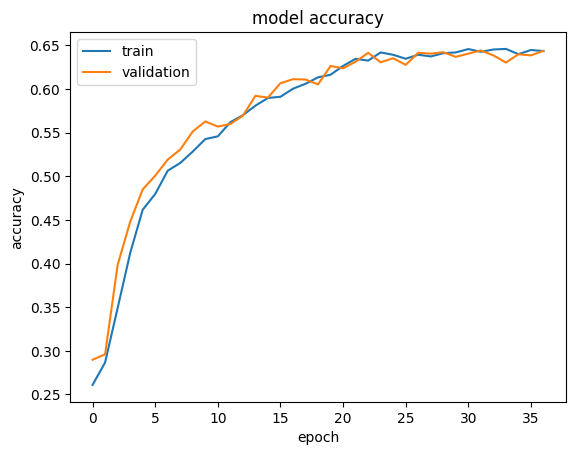

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
model1.evaluate(test_set)

78/78 [==============================] - 2s 29ms/step - loss: 0.8152 - accuracy: 0.6892


[0.8151885271072388, 0.6891701817512512]

### Plotting the confussion matrix

78/78 [==============================] - 2s 24ms/step
Class 0 - F1_score: 0.80, Precision: 0.83, Recall: 0.77
Class 1 - F1_score: 0.60, Precision: 0.56, Recall: 0.65
Class 2 - F1_score: 0.55, Precision: 0.56, Recall: 0.55
Class 3 - F1_score: 0.78, Precision: 0.79, Recall: 0.77


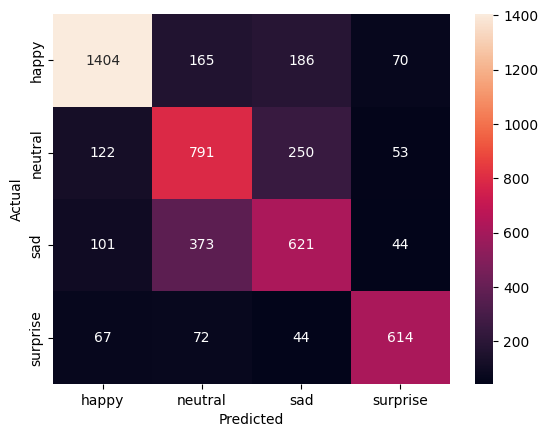

In [ ]:
# Get predictions from the model for the test set
y_pred = model1.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

**Observations:** The model is performing with a low level of overfitting, as the accuracy in the best epoch is very similar across the validation, test, and training sets. The final test set accuracy is 0.69, with the best-performing categories being Happy and Surprise, which raise the F1 score to 0.8 and 0.75 respectively. However, Sad and Neutral categories perform poorly in terms of F1 score, barely breaking the 0.6 mark. We find this paradoxical result where the test set accuracy is higher than the validation or training accuracy.

# **Trying the same model in gray scale**

The photos are in gray scale so we will test the model using the images in gray scale.



In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

IMG_SIZE = 48
BATCH_SIZE = 64

# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.2, 1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2
)

# Create the test data generator with normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


In [ ]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# The input_shape denotes input image dimension
model2.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same", input_shape = (48, 48, 1)))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model2.add(Dropout(0.2))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPool2D((2, 2), padding = 'same'))

# Adding second conv layer with 32 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model2.add(Conv2D(32, (3, 3), activation = 'relu', padding = "same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model2.add(Dropout(0.2))

model2.add(MaxPool2D((2, 2), padding = 'same'))

# Add third conv layer with 32 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model2.add(Dropout(0.2))

model2.add(MaxPool2D((2, 2), padding = 'same'))

# Adding fourth conv layer with 16 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model2.add(Conv2D(16, (3, 3), activation = 'relu', padding = "same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model2.add(Dropout(0.2))

model2.add(MaxPool2D((2, 2), padding = 'same'))

# Add fifth conv layer with 16 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))

#  Adding dropout to randomly switch off 20% neurons to reduce overfitting
model2.add(Dropout(0.2))

model2.add(MaxPool2D((2, 2), padding = 'same'))

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections using GAP
model2.add(GlobalAveragePooling2D())

# Adding the output layer with 4 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(4, activation = 'softmax'))

# Using Adam Optimizer
opt = Adam(learning_rate = 0.001)

# Compiling the model
model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                    

### **Compiling and Training the Model**

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model2.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# Fitting the model with 100 epochs with the callbacks defined above.
history=model2.fit(train_set,
                   validation_data = val_set,
          epochs = 100,
          callbacks = [es, mc, rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.3804 - accuracy: 0.2669
Epoch 1: val_accuracy improved from -inf to 0.29145, saving model to best_model2.h5
191/191 [==============================] - 19s 86ms/step - loss: 1.3804 - accuracy: 0.2669 - val_loss: 1.3755 - val_accuracy: 0.2914 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.3582 - accuracy: 0.3121
Epoch 2: val_accuracy improved from 0.29145 to 0.34605, saving model to best_model2.h5
191/191 [==============================] - 16s 85ms/step - loss: 1.3582 - accuracy: 0.3121 - val_loss: 1.3385 - val_accuracy: 0.3461 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.2711 - accuracy: 0.3825
Epoch 3: val_accuracy improved from 0.34605 to 0.41579, saving model to best_model2.h5
191/191 [==============================] - 16s 84ms/step - loss: 1.2711 - accuracy: 0.3825 - val_loss: 1.2677 - val_accuracy: 0.4158 - lr: 0.0010
Epoch 4/100
1

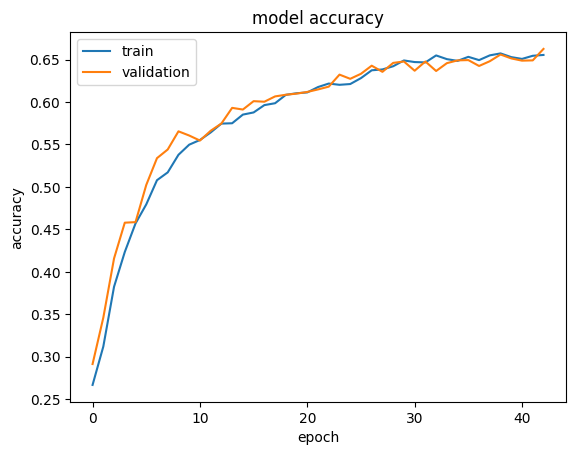

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
model2.evaluate(test_set)

78/78 [==============================] - 2s 30ms/step - loss: 0.7876 - accuracy: 0.6994


[0.7875926494598389, 0.6994172930717468]

### Plotting the confussion matrix

78/78 [==============================] - 2s 21ms/step
Class 0 - F1_score: 0.8141, Precision: 0.8086, Recall: 0.8197
Class 1 - F1_score: 0.6158, Precision: 0.5719, Recall: 0.6669
Class 2 - F1_score: 0.5382, Precision: 0.6037, Recall: 0.4855
Class 3 - F1_score: 0.7811, Precision: 0.7831, Recall: 0.7792


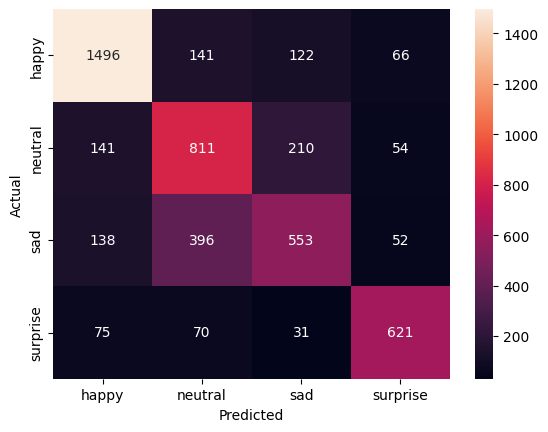

In [ ]:
# Get predictions from the model for the test set
y_pred = model2.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The model is performing very similarly to the model with RGB. Again, overfitting seems to be minimal, as the accuracy performance in the best epoch is very similar across the validation, test (being higher in this one), and training sets. The model is faster per epoch; thus, we will use grayscale over RGB from now on. The final test set accuracy is 0.69, with the best categories being Happy and Surprise, raising the F1 scores to 0.80 and 0.79, respectively. However, Sad and Neutral categories perform poorly, with F1 scores barely breaking the 0.6 mark. Once again, we observe higher test accuracy than training and validation sets.

# **Trying a more complex model**

We are gonna assume there is gonna be overfitting so to fight it we will use dropout, and/or BatchNormalization. Dropout worked worst than Batch_normalization who succeded at reducing overfiting.However, only with Batch Normalization the model was still overfitting, thus, dropout of increasing range was included after the maxpooling, as seen in other atchitectures. Similarly to with the last model Adam optimizer lead to the best performance in accuracy and/or the epochs that took to arrive there. Also we tried Relu activation and Rekyrelu, been this one more effective in increasaing accuracy in training and validation. Therefore we will start with a relatively complex model. Such model contains:
- One stack of three layers that start with a convolution layer with 64 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 3x3 and stride 3x3, follow by a Dropout layer (25%)
- One stack of three layers that start with a convolution layer with 96 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 3x3 and stride 3x3, follow by a Dropout layer (40%)
- One stack of three layers that start with a convolution layer with 128 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 3x3 and stride 3x3, follow by a Dropout layer (50%)
- Flatening using Global Avarage Pooling
- Output layer with 4 neurons and softmax activation.
- Adam optimizer learning rate of 0.001.
- Compile the model using categorical_crossentropy and accuracy as the metric



In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Creating the Base Neural Network**

In [19]:
# Initializing a sequential model
model3 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
# The input_shape denotes input image dimension
model3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None, input_shape = (48, 48, 1)))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding second conv layer with 64 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding third conv layer with 64 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer pool_size 3*3 and strides 3*3
model3.add(MaxPool2D(pool_size = (3, 3), strides = (3, 3)))

# Adding Dropout of 25%
model3.add(Dropout(0.25))

# Adding fourth conv layer with 96 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 96, kernel_size = (3, 3), padding = 'Same', activation = None ))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding fifth conv layer with 96 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 96, kernel_size = (3, 3), padding = 'Same', activation = None ))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding sixth conv layer with 96 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 96, kernel_size = (3, 3), padding = 'Same', activation = None ))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer pool_size 3*3 and strides 3*3
model3.add(MaxPool2D(pool_size = (3, 3), strides = (3, 3)))

# Adding Dropout of 40%
model3.add(Dropout(0.4))

# Adding seventh conv layer with 128 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding eigth conv layer with 128 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding ninth conv layer with 128 filters and kernel size 3*3, Batch normalization, and RekyReLU activation and padding 'same' provides the output size same as the input size
model3.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None))

model3.add(BatchNormalization())

model3.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model3.add(MaxPool2D(pool_size = (3, 3), strides = (3, 3)))

# Adding Dropout of 50%
model3.add(Dropout(0.5))

model3.add(GlobalAveragePooling2D())

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model3.add(Dense(4, activation = "softmax"))

# Using SGD Optimizer
opt = Adam(learning_rate = 0.001)

# Compile the model
model3.compile(optimizer = opt , loss = "categorical_crossentropy", metrics = ["accuracy"])

model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 48, 48, 64)       

### **Compiling and Training the Model**

In [20]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model3.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# Fitting the model with 100 epochs with the callbacks defined above.
history=model3.fit(train_set,
          validation_data = val_set,
          epochs = 100,
          callbacks = [es, mc, rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.5609 - accuracy: 0.2715
Epoch 1: val_accuracy improved from -inf to 0.22467, saving model to best_model3.h5
191/191 [==============================] - 27s 108ms/step - loss: 1.5609 - accuracy: 0.2715 - val_loss: 1.4058 - val_accuracy: 0.2247 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.3299 - accuracy: 0.3429
Epoch 2: val_accuracy improved from 0.22467 to 0.29309, saving model to best_model3.h5
191/191 [==============================] - 19s 97ms/step - loss: 1.3299 - accuracy: 0.3429 - val_loss: 1.4429 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.4620
Epoch 3: val_accuracy improved from 0.29309 to 0.47829, saving model to best_model3.h5
191/191 [==============================] - 21s 109ms/step - loss: 1.1854 - accuracy: 0.4620 - val_loss: 1.1264 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 4/100

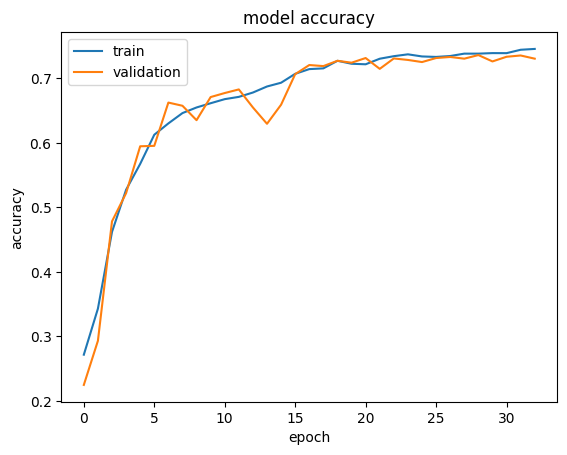

In [21]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [22]:
model3.evaluate(test_set)

78/78 [==============================] - 2s 25ms/step - loss: 0.6112 - accuracy: 0.7611


[0.611240565776825, 0.7611010670661926]

### **Plotting the confussion matrix**

78/78 [==============================] - 2s 22ms/step
Class 0 - F1_score: 0.8565, Precision: 0.8993, Recall: 0.8175
Class 1 - F1_score: 0.6809, Precision: 0.6234, Recall: 0.7500
Class 2 - F1_score: 0.6413, Precision: 0.6811, Recall: 0.6058
Class 3 - F1_score: 0.8469, Precision: 0.8242, Recall: 0.8708


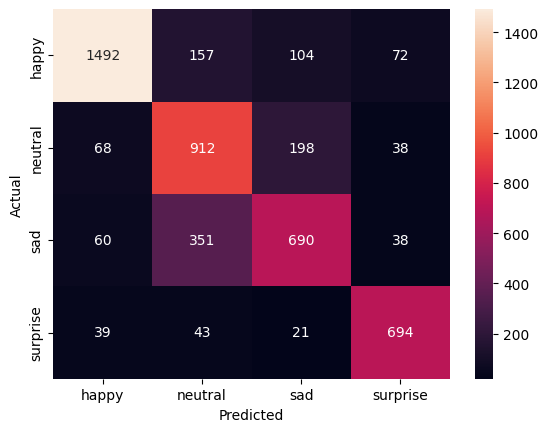

In [23]:
# Get predictions from the model for the test set
y_pred = model3.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The model outperforms the other one in accuracy, rising to 0.76, with minimal overfitting. The same pattern persists, where the accuracy is slightly higher in the test compared to training and validation sets. Additionally, the best-performing categories remain to be happy and surprise, with neutral and sad underperforming.

# **Training a deeper model**

The model before was effective and didn't suffer of overfitting. We will know try a deeper model that may be capable of arriving to a greater solution. However a deeper model could lead to overfitting. The model consists of:

- One stack of five layers that start with a convolution layer with 32 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 2x2 and stride 2x2, follow by a Dropout layer (20%)
- One stack of five layers that start with a convolution layer with 64 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 2x2 and stride 2x2, follow by a Dropout layer (30%)
- One stack of five layers that start with a convolution layer with 128 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 2x2 and stride 2x2, follow by a Dropout layer (40%)
- One stack of five layers that start with a convolution layer with 256 filters, kernel size 3x3, padding same, a Batch Normalization layer, RekyRelu activation, then a maxpool layer with poolsize 2x2 and stride 2x2, follow by a Dropout layer (50%)
- Flatening using Global Avarage Pooling
- Output layer with 4 neurons and softmax activation.
- Adam optimizer learning rate of 0.001.
- Compile the model using categorical_crossentropy and accuracy as the metric


In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Creating the Base Neural Network**

In [ ]:
# Initializing a sequential model
model4 = Sequential()

# Adding first conv layer with 32 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
# The input_shape denotes input image dimension
model4.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = None, input_shape = (48, 48, 1)))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding second conv layer with 32 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding third conv layer with 32 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters =32, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())


# Adding max pooling to reduce the size of output of first conv layer
model4.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

# Adding Dropout of 20%
model4.add(Dropout(0.2))

# Adding first conv layer with 64 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding second conv layer with 64 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding third conv layer with 64 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model4.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

# Adding Dropout layer of 30%
model4.add(Dropout(0.3))

# Adding first conv layer with 128 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None ))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding second conv layer with 128 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None ))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding third conv layer with 128 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None ))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model4.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

# Adding Dropout layer 40%
model4.add(Dropout(0.4))

# Adding first conv layer with 256 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding second conv layer with 256 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding third conv layer with 256 filters and kernel size 3x3, with LeakyReLU activation and padding 'same' provides the output size same as the input size
model4.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model4.add(BatchNormalization())

model4.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model4.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

# Adding Dropout 50%
model4.add(Dropout(0.5))

model4.add(GlobalAveragePooling2D())

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model4.add(Dense(4, activation = "softmax"))

# Using SGD Optimizer
opt = Adam(learning_rate = 0.001)

# Compile the model
model4.compile(optimizer = opt , loss = "categorical_crossentropy", metrics = ["accuracy"])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0

## **Compiling and training the model**

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience =5, restore_best_weights = True)
mc = ModelCheckpoint('best_model4.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# Fitting the model with 100 epochs with the callbacks defined above.
history=model4.fit(train_set,
          validation_data = val_set,
          epochs = 100,
          batch_size= 64,
          callbacks = [es, mc, rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.3540
Epoch 1: val_accuracy improved from -inf to 0.26447, saving model to best_model4.h5
191/191 [==============================] - 29s 109ms/step - loss: 1.3773 - accuracy: 0.3540 - val_loss: 1.4361 - val_accuracy: 0.2645 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.1272 - accuracy: 0.4936
Epoch 2: val_accuracy improved from 0.26447 to 0.50263, saving model to best_model4.h5
191/191 [==============================] - 18s 93ms/step - loss: 1.1272 - accuracy: 0.4936 - val_loss: 1.1622 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.5705
Epoch 3: val_accuracy improved from 0.50263 to 0.59079, saving model to best_model4.h5
191/191 [==============================] - 21s 109ms/step - loss: 0.9925 - accuracy: 0.5705 - val_loss: 1.0117 - val_accuracy: 0.5908 - lr: 0.0010
Epoch 4/100

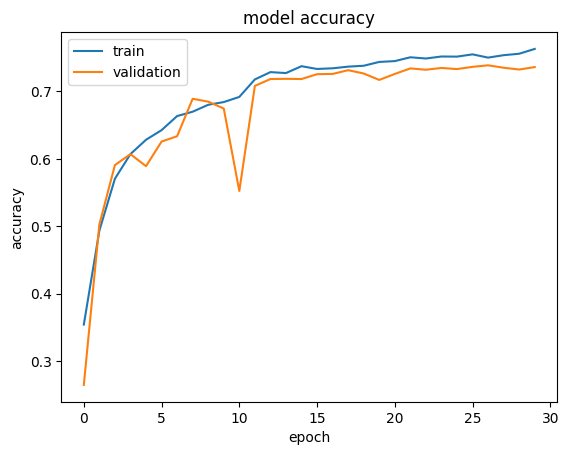

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
model4.evaluate(test_set)

78/78 [==============================] - 2s 27ms/step - loss: 0.5919 - accuracy: 0.7655


[0.5918781161308289, 0.7655214071273804]

### Plotting the confussion matrix

78/78 [==============================] - 2s 24ms/step
Class 0 - F1_score: 0.8588, Precision: 0.8920, Recall: 0.8279
Class 1 - F1_score: 0.6842, Precision: 0.6380, Recall: 0.7377
Class 2 - F1_score: 0.6516, Precision: 0.6857, Recall: 0.6207
Class 3 - F1_score: 0.8460, Precision: 0.8215, Recall: 0.8720


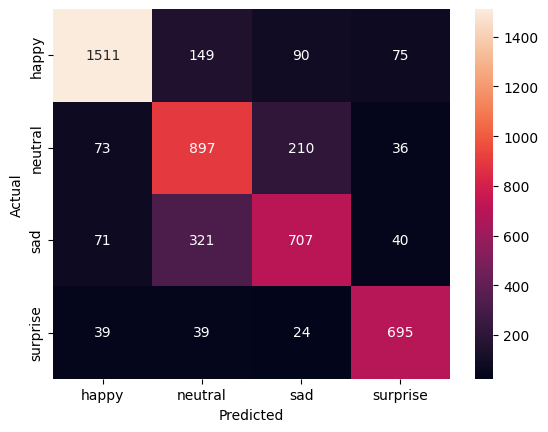

In [ ]:
# Get predictions from the model for the test set
y_pred = model4.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations**: The model did not improve upon the performance of our last model despite the added complexity. In this case, the overfitting was slightly higher, with training accuracy slightly more elevated compared to model three. We still observe higher accuracy in the test set compared to the training and validation sets. Therefore, we believe that model three is the best model we have created thus far.

### **Final remarks:**

These architectures have yielded an accuracy of 0.77. Despite attempting various tweaks, which were discussed in the Notebook but not shown, we were unable to improve beyond this accuracy level. The simpler architecture initially led to a 0.69 accuracy, slightly lower than the more complex one. However, all architectures resulted in a significant level of overfitting. As our next step, we will try four different transfer models to see if we can achieve better performance.

# **Transfer Learning Architectures**

In this section, we will create several transfer learning architectures. For the pre-trained models, we will select four popular architectures: MobileNetV3, EfficientNet, VGG16, and ResNet v2. MobileNet and EfficientNet come with their own preprocessors inside the model, so the data should be fed unnormalized. We will create RGB data loaders that are not normalized, as the models require this kind of preprocessing.

In [ ]:
train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

CATEGORIES = ["happy", "sad",'surprise', "neutral"]
IMG_SIZE = 48
BATCH_SIZE = 64


# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    brightness_range=(0.2,1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.3,
    validation_split=0.2,
)

# Create the test data generator with normalization
test_datagen = ImageDataGenerator()

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


## **Mobile NET V3**

Mobile Net preprocesses the data input inside the model so the unnormalized data will be directly introduced in the model. The model weights of imagenet are train in colour pictures with higher resolution, thus the weights were retrained.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load MobileNetV3Small model with weights imagenet.
input_shape = (48, 48,3)
base_model = MobileNetV3Small(weights='imagenet', include_top=False,  input_shape=input_shape)

# The model is fast so we will load it completely and make the layers not trainable

base_model.trainable = True


# Add new layers on top of Mobile net. The layers include dropout, GAP to flatten the results and one Dense layers of 1024 neurons
# and 64 neurons with an output layer of 4 neurons. The optimizer will be Adam with 0.01 learning rate:
x = base_model.output

x = Dropout (0.3)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

x = Dropout (0.4) (x)

predictions = Dense(4, activation='softmax')(x)

# Create new model
model5 = Model(inputs=base_model.input, outputs=predictions)

optimizer =  Adam(learning_rate = 0.01)

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model5.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 24, 24, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 24, 24, 16)  64          ['Conv[0][0]']                   
 tion)                         

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model5.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# Fitting the model with 100 epochs and validation_split as 20% with the callbacks defined above.
history=model5.fit(train_set,
          epochs = 100,
          validation_data = val_set,
          callbacks = [es, mc, rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.3772
Epoch 1: val_accuracy improved from -inf to 0.29704, saving model to best_model5.h5
191/191 [==============================] - 57s 144ms/step - loss: 1.3650 - accuracy: 0.3772 - val_loss: 1.6292 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.1013 - accuracy: 0.5175
Epoch 2: val_accuracy improved from 0.29704 to 0.39638, saving model to best_model5.h5
191/191 [==============================] - 25s 133ms/step - loss: 1.1013 - accuracy: 0.5175 - val_loss: 1.3989 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.5686
Epoch 3: val_accuracy did not improve from 0.39638
191/191 [==============================] - 25s 132ms/step - loss: 1.0043 - accuracy: 0.5686 - val_loss: 1.5758 - val_accuracy: 0.3885 - lr: 0.0010
Epoch 4/100
191/191 [=========================

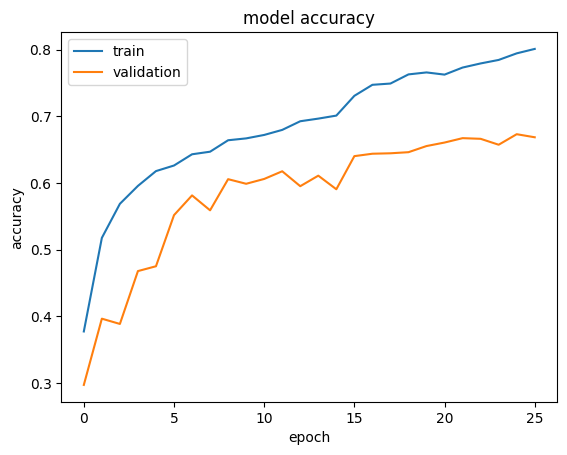

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
model5.evaluate(test_set)

78/78 [==============================] - 3s 33ms/step - loss: 0.7596 - accuracy: 0.7024


[0.759620189666748, 0.7024312019348145]

### Plotting the confusion matrix

78/78 [==============================] - 4s 36ms/step
Class 0 - F1_score: 0.8007, Precision: 0.8185, Recall: 0.7836
Class 1 - F1_score: 0.6177, Precision: 0.5625, Recall: 0.6850
Class 2 - F1_score: 0.5706, Precision: 0.6176, Recall: 0.5303
Class 3 - F1_score: 0.8023, Precision: 0.8158, Recall: 0.7892


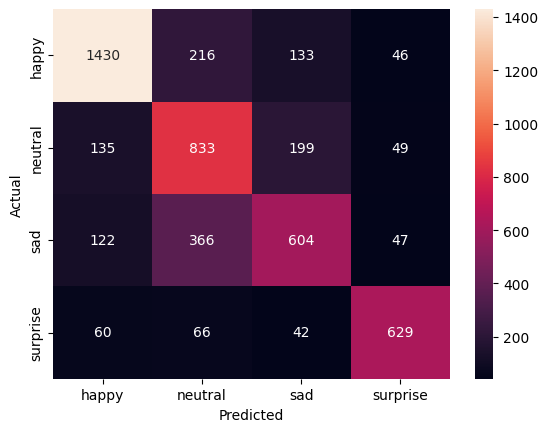

In [ ]:
# Get predictions from the model for the test set
y_pred = model5.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The model is fast, but it also suffers from overfitting, resulting in weaker results compared to the models we built ourselves.

# Efficient Net

Efficent Net preprocesses the data input inside the model so the unnormalized data will be directly introduced in the model. The model was not overfitting and learning little from epoch to epoch so we didn't introduced dropout. The model is trained in imagenet which had higher resolution than our images as well as colour images. This we retrained the model.

In [ ]:
train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

CATEGORIES = ["happy", "sad",'surprise', "neutral"]
IMG_SIZE = 48
BATCH_SIZE = 64


# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    brightness_range=(0.2,1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.3,
    validation_split=0.2,
)

# Create the test data generator with normalization
test_datagen = ImageDataGenerator()

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B2

import tensorflow.keras.applications as ap
# Load EfficientNetB7 model weight imagenet and input shape (48,48,3)
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                                                                                  

In [ ]:
# Defining the layers we are going to use and setting the Efficient Net layers to untrainable.
base_model = EfficientNet
for layer in base_model.layers[:200]:
      layer.trainable = False
for layer in base_model.layers[200:]:
      layer.trainable = True

# Add the new layers GAP, Dense layers of 1024 neurons and ropout of 50% and an ouput layer of 4 neurons.

x = GlobalAveragePooling2D()  (base_model.output)

x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

x = Dropout (0.5) (x)

output = Dense(4, activation='softmax')(x)

# Create the new model
model6 = Model(inputs=base_model.input, outputs=output)

#Adam optimiAzer learning_rate= 0.001
optimizer = Adam(learning_rate = 0.01)

# Compile the model
model6.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model6.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                                                                                            

### **Compiling and training the model**

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
# The other moels have higher patiene for the two measures cause the overfitting was minimal. Here increasing the patience leas to a better accuracy
# in the test data with higher overfitting so we restore the patience to 5 and 3.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model6.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# Fitting the model with 100 epochs and validation_split as 20% with the callbacks defined above.
history=model6.fit(train_set,
          epochs = 100,
          validation_data = val_set,
          callbacks = [es, mc, rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 2.6891 - accuracy: 0.4831
Epoch 1: val_accuracy improved from -inf to 0.57303, saving model to best_model6.h5
191/191 [==============================] - 71s 168ms/step - loss: 2.6891 - accuracy: 0.4831 - val_loss: 1.3294 - val_accuracy: 0.5730 - lr: 0.0100
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.2957 - accuracy: 0.5621
Epoch 2: val_accuracy improved from 0.57303 to 0.57697, saving model to best_model6.h5
191/191 [==============================] - 28s 146ms/step - loss: 1.2957 - accuracy: 0.5621 - val_loss: 1.1878 - val_accuracy: 0.5770 - lr: 0.0100
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.5815
Epoch 3: val_accuracy improved from 0.57697 to 0.61184, saving model to best_model6.h5
191/191 [==============================] - 28s 148ms/step - loss: 1.1953 - accuracy: 0.5815 - val_loss: 1.1304 - val_accuracy: 0.6118 - lr: 0.0100
Epoch 4/10

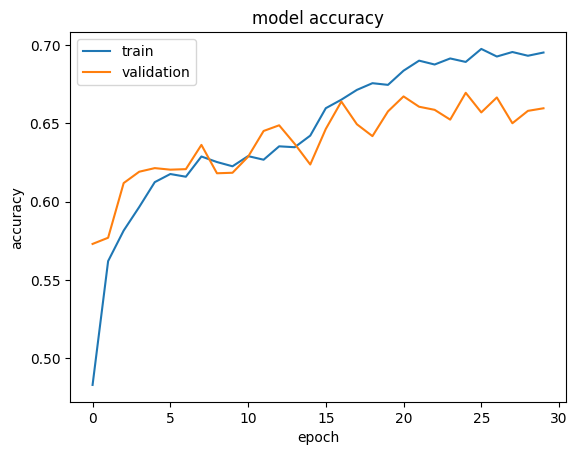

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
model6.evaluate(test_set)

78/78 [==============================] - 3s 38ms/step - loss: 0.7569 - accuracy: 0.6992


[0.7568619251251221, 0.699216365814209]

### Plotting the confusion matrix

78/78 [==============================] - 5s 29ms/step
Class 0 - F1_score: 0.7987, Precision: 0.8179, Recall: 0.7803
Class 1 - F1_score: 0.6100, Precision: 0.5871, Recall: 0.6349
Class 2 - F1_score: 0.6001, Precision: 0.6096, Recall: 0.5909
Class 3 - F1_score: 0.7571, Precision: 0.7479, Recall: 0.7666


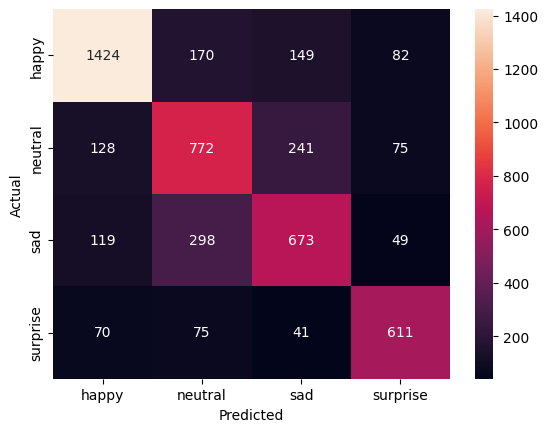

In [ ]:
# Get predictions from the model for the test set
y_pred = model6.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** Once again, the model is performing worse than our most complex architectures and is also exhibiting overfitting. Therefore, we do not believe this architecture makes sense for our task.

In [ ]:

train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

CATEGORIES = ["happy", "sad",'surprise', "neutral"]
IMG_SIZE = 48
BATCH_SIZE = 64


# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    brightness_range=(0.2,1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.3,
    validation_split=0.2,
    rescale= 1/255
    )

# Create the test data generator with normalization
test_datagen = ImageDataGenerator(rescale= 1/255)

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


# **VGG16 Model**

The documentation of the model recommends using preprocess_input for your input before passing it to the model. However, using the preprocess unit included in the documentation led to worse results than normalizing by dividing by 255, so we opted for the latter approach instead. We experimented with a set of different combinations, including dropouts and varying depths into the VGG16 model, but we were unable to find a model that learned effectively. We found that reducing the last stack of convolutional layers helped the model learn better, so we implemented this modification.

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Importing the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

### **Model Building**

In [ ]:
# Load VGG16, weight imagenet and input_shape(48,48,3)
VGG16 = VGG16(include_top=False, weights="imagenet", input_shape= (48, 48, 3))

VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Compiling and Training the VGG16 Model**

In [ ]:
#VGG16 is heavy in computational load and going deeper didn't lead to better performance. Thus we use just a few stacked Conv
#layers and set their wieghts to untrainable.
transfer_layer = VGG16.get_layer('block4_pool').output

for layer in VGG16.layers:
      layer.trainable = False


#Add the new layers inclugin GAP, two Dense layers 128 and 64 and an ouput layer of 4 neurons.
x = GlobalAveragePooling2D() (transfer_layer)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)

predictions = Dense(4, activation='softmax')(x)

#Add an optimizer of learning_rate 0.001 adam.
opt = Adam(learning_rate = 0.001)

#Create the new model
model7 = Model(inputs=VGG16.input, outputs=predictions)

#Compile the model
model7.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model7.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# Fitting the model with 100 epochs and validation_split as 20% with the callbacks defined above.
history=model7.fit(train_set,
          epochs = 100,
          validation_data = val_set,
          callbacks = [es, mc,rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.4027 - accuracy: 0.4358
Epoch 1: val_accuracy improved from -inf to 0.50954, saving model to best_model7.h5
191/191 [==============================] - 26s 128ms/step - loss: 1.4027 - accuracy: 0.4358 - val_loss: 1.1172 - val_accuracy: 0.5095 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.1565 - accuracy: 0.4760
Epoch 2: val_accuracy improved from 0.50954 to 0.52204, saving model to best_model7.h5
191/191 [==============================] - 23s 119ms/step - loss: 1.1565 - accuracy: 0.4760 - val_loss: 1.0914 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.1174 - accuracy: 0.5099
Epoch 3: val_accuracy improved from 0.52204 to 0.52993, saving model to best_model7.h5
191/191 [==============================] - 24s 126ms/step - loss: 1.1174 - accuracy: 0.5099 - val_loss: 1.0859 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 4/10

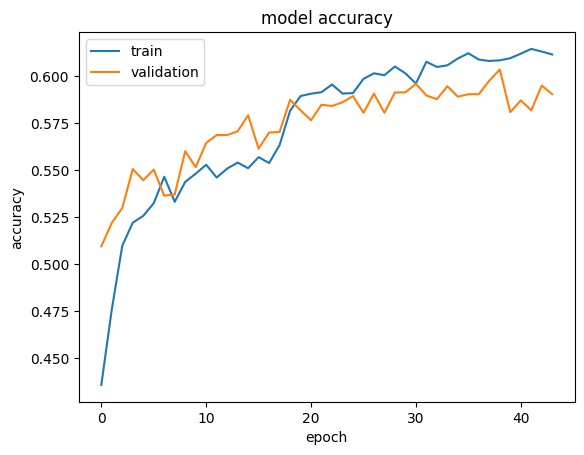

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the VGG16 model**

In [ ]:
model7.evaluate(test_set)

78/78 [==============================] - 3s 35ms/step - loss: 0.8573 - accuracy: 0.6500


[0.8573397397994995, 0.6499899625778198]

### Plotting the confusion matrix

78/78 [==============================] - 3s 32ms/step
Class 0 - F1_score: 0.7360, Precision: 0.7516, Recall: 0.7211
Class 1 - F1_score: 0.5716, Precision: 0.5244, Recall: 0.6283
Class 2 - F1_score: 0.5339, Precision: 0.5756, Recall: 0.4978
Class 3 - F1_score: 0.7438, Precision: 0.7500, Recall: 0.7378


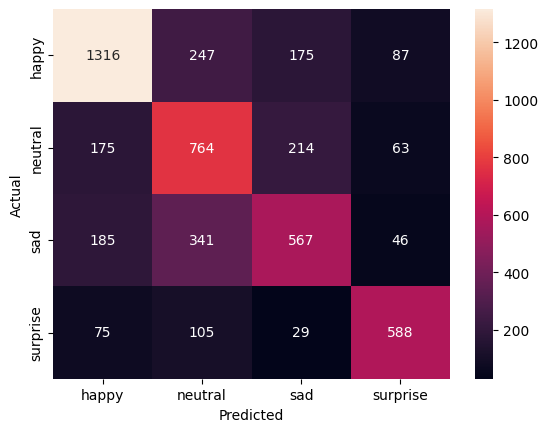

In [ ]:
# Get predictions from the model for the test set
y_pred = model7.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The model consistently underperformed in all aspects. It struggled to improve beyond 0.6 in both the training and validation sets. Additionally, it was slow in each iteration. Consequently, we believe this architecture is not usable for our purposes, despite the model not exhibiting significant overfitting.

## **ResNet V2 Model**

The information on the model say that the data had to be preprocessed, however, similar to with VGG16 when using the preprocess data the model was not generalizable to the test set, underperforming there. Therefore, we used the normalized augmented set.

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:

train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

CATEGORIES = ["happy", "sad",'surprise', "neutral"]
IMG_SIZE = 48
BATCH_SIZE = 64


# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    brightness_range=(0.2,1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.3,
    validation_split=0.2,
    rescale= 1/255
    )

# Create the test data generator with normalization
test_datagen = ImageDataGenerator(rescale= 1/255)

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


In [ ]:
import tensorflow.keras.applications as ap
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# Load EfficientNet50V2 model imagenet weights and input_shape (48,48,3)
ResNet50V2 = ResNet50V2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

ResNet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

### **Model Building**

In [ ]:
for layer in ResNet50V2.layers[:180]:
      layer.trainable = False
for layer in ResNet50V2.layers[180:]:
      layer.trainable = True

# Add the new layers been a GAP layer and two Dense layers of 128 and 64 neurons. We create an output layer of 4 neurons.
x = GlobalAveragePooling2D() (ResNet50V2.output)

x = Dense(1024, activation='relu')(x)

predictions = Dense(4, activation='softmax')(x)

# Optimizer Adam learning rate 0.01.
optimizer = Adam(learning_rate = 0.01)

# Create the new model
model8 = Model(inputs=ResNet50V2.input, outputs=predictions)

# Compile the model
model8.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

### **Compiling and Training the Model**

In [ ]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be reduced.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model8.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# Fitting the model with 100 epochs and the callbacks defined above.
history=model8.fit(train_set,
          epochs = 100,
          validation_data = val_set,
          callbacks = [es, mc,rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.4530 - accuracy: 0.4103
Epoch 1: val_accuracy improved from -inf to 0.45724, saving model to best_model8.h5
191/191 [==============================] - 33s 139ms/step - loss: 1.4530 - accuracy: 0.4103 - val_loss: 1.2308 - val_accuracy: 0.4572 - lr: 0.0100
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.1717 - accuracy: 0.4903
Epoch 2: val_accuracy improved from 0.45724 to 0.51842, saving model to best_model8.h5
191/191 [==============================] - 25s 129ms/step - loss: 1.1717 - accuracy: 0.4903 - val_loss: 1.1305 - val_accuracy: 0.5184 - lr: 0.0100
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.1362 - accuracy: 0.5163
Epoch 3: val_accuracy did not improve from 0.51842
191/191 [==============================] - 25s 130ms/step - loss: 1.1362 - accuracy: 0.5163 - val_loss: 1.1884 - val_accuracy: 0.4868 - lr: 0.0100
Epoch 4/100
191/191 [=========================

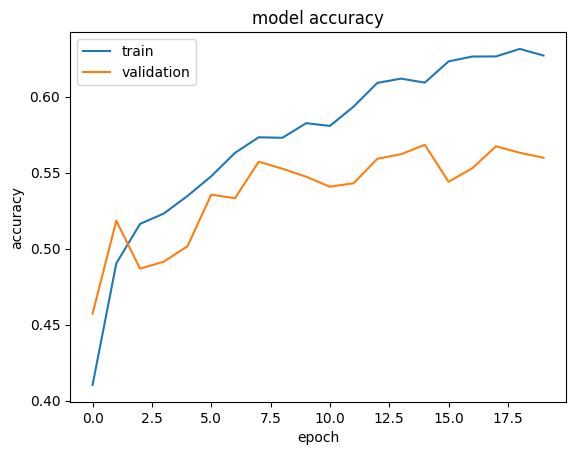

In [ ]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the ResNet Model**

In [ ]:
model8.evaluate(test_set)

78/78 [==============================] - 3s 43ms/step - loss: 0.9859 - accuracy: 0.5911


[0.9858636856079102, 0.5911191701889038]

### Plotting the confusion matrix

78/78 [==============================] - 3s 29ms/step
Class 0 - F1_score: 0.6704, Precision: 0.7204, Recall: 0.6268
Class 1 - F1_score: 0.5134, Precision: 0.4857, Recall: 0.5444
Class 2 - F1_score: 0.5064, Precision: 0.5107, Recall: 0.5022
Class 3 - F1_score: 0.6624, Precision: 0.6225, Recall: 0.7077


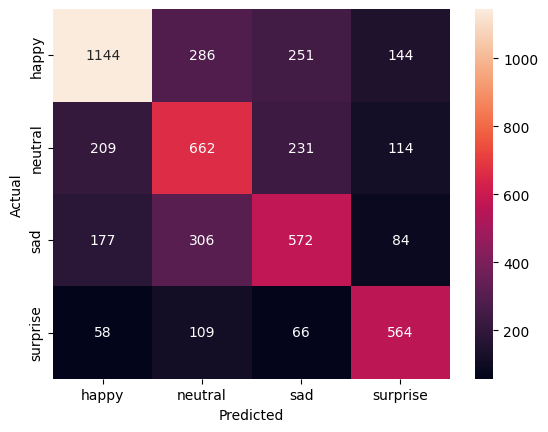

In [ ]:
# Get predictions from the model for the test set
y_pred = model8.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The model achieved an accuracy of 0.59, which is lower than the accuracies obtained by the fully trained models we built ourselves. Additionally, these transfer models weren't necessarily faster than our custom-built models.

**Final remarks in transfer learning:** The models used in this section were all trained on color image datasets, whereas our images were grayscale. This discrepancy may have contributed to the lower performance of these transfer models. Moreover, the models were primarily trained on ImageNet, where the pixel per image is significantly greater than the 48x48 resolution used in our training. This, combined with the grayscale nature of our images and the fact that the weights used correspond to models trained on ImageNet, likely contributed to the lower accuracy compared to our fully trained models. Despite attempting to mitigate these issues by retraining layers of the model, we were unable to achieve better results than before.

## **Building a Complex Neural Network Architecture based on our model and VGG16**

Following the architectures above we will built a model that stacks together a bunch of conv layers that increase in filters. These groups of conv layers will be follow by maxpooling and have in the middle some kind of dropout to decrease the overfitting. The architectures try to mix the ideas behind architectures like VGG16 together with what we learn from our own models. The model was:
- Two stacks of one Conv2D layer with 32 filters, kernel size (3x3), followed by Batch Normalization and RekyRelu activation
- A maxpooling layer of pool size (2x2) and stride (2x2).
- Dropout layer 15%.
- Two stacks of one Conv2D layer with 64 filters, kernel size (3x3), followed by Batch Normalization and RekyRelu activation
- A maxpooling layer of pool size (2x2) and stride (2x2).
- Dropout layer 20%.
- Three stacks of one Conv2D layer with 128 filters, kernel size (3x3),followed by Batch Normalization and RekyRelu activation
- A maxpooling layer of pool size (2x2) and stride (2x2).
- Dropout layer 30%.
- Three stacks of one Conv2D layer with 256 filters, kernel size (3x3) followed by Batch Normalization and RekyRelu activation
- Dropout layer of 35%
- Three stacks of one Conv2D layer with 512 filters, kernel size (3x3) followed by Batch Normalization and RekyRelu activation
- Dropout layer of 40%
- Three stacks of one Conv2D layer with 512 filters, kernel size (3x3) followed by Batch Normalization and RekyRelu activation
- Dropout layer of 50%
- A Global Avarage pooling layer trying to flatten the results.
- A 4 dense output layer with softmax activation.
- Adam optimizer with learning rate 0.0001 as the model was learning extremely fast with lower optimizers.
- Compiler with categorical crossentropy loss and Accuracy as metric.

In [6]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [7]:
train_dir=  'Facial_emotion_images/train'
test_dir=  'Facial_emotion_images/validation'

CATEGORIES = ["happy", "sad",'surprise', "neutral"]
IMG_SIZE = 48
BATCH_SIZE = 64


# Create the train data generator with augmentations
train_datagen = ImageDataGenerator(
    brightness_range=(0.2,1.8),
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.3,
    validation_split=0.2,
    rescale=1./255
)

# Create the test data generator with normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train data
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42,
    subset='training'
)

# Load the validation data
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42,
    subset='validation'
)

# Load the test data
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 12171 images belonging to 4 classes.
Found 3040 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


In [8]:
# Initializing a sequential model
model9 = Sequential()

# Adding first conv layer with 32 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model9.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = None, input_shape = (48, 48, 1)))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding second conv layer with 32 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model9.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 0.15%
model9.add(Dropout(0.15))

# Adding first conv layer with 64 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None ))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding second conv layer with 64 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None ))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model9.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 20%
model9.add(Dropout(0.2))

# Adding first conv layer with 128 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding second conv layer with 128 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding third conv layer with 128 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model9.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 30%
model9.add(Dropout(0.3))

# Adding first conv layer with 256 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding second conv layer with 256 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding third conv layer with 256 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model9.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 35%
model9.add(Dropout(0.35))

# Adding first conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding second conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding third conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Dropout 40%
model9.add(Dropout(0.4))

# Adding first conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding second conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding third conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation
model9.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model9.add(BatchNormalization())

model9.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model9.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 50%
model9.add(Dropout(0.5))

model9.add(GlobalAveragePooling2D())

# Adding the output layer with 4 neurons and activation functions as softmax since this is a multi-class classification problem
model9.add(Dense(4, activation = "softmax"))

# Using Adam Optimizer
opt = Adam(learning_rate = 0.001)

# Compile the model
model9.compile(optimizer = opt , loss = "categorical_crossentropy", metrics = ["accuracy"])

model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0

## **Compiling and training the model**

In [9]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be
# by reducing the learning rate.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model9.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# Fitting the model with 100 epochs with the callbacks defined above.
history=model9.fit(train_set,
          epochs = 100,
          validation_data = val_set,
          callbacks = [es, mc,rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.8921 - accuracy: 0.2651
Epoch 1: val_accuracy improved from -inf to 0.26316, saving model to best_model9.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 41s 115ms/step - loss: 1.8921 - accuracy: 0.2651 - val_loss: 1.3942 - val_accuracy: 0.2632 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.5393 - accuracy: 0.2668
Epoch 2: val_accuracy improved from 0.26316 to 0.26480, saving model to best_model9.h5
191/191 [==============================] - 21s 112ms/step - loss: 1.5393 - accuracy: 0.2668 - val_loss: 1.3859 - val_accuracy: 0.2648 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.4187 - accuracy: 0.2654
Epoch 3: val_accuracy improved from 0.26480 to 0.27632, saving model to best_model9.h5
191/191 [==============================] - 18s 95ms/step - loss: 1.4187 - accuracy: 0.2654 - val_loss: 1.3789 - val_accuracy: 0.2763 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - ETA: 0s - loss: 1.3883 - accuracy: 0.2692
Epoch 4: val_accuracy improved from 0.27632 to 0.29013, saving model to best_model9.h5
191/191 

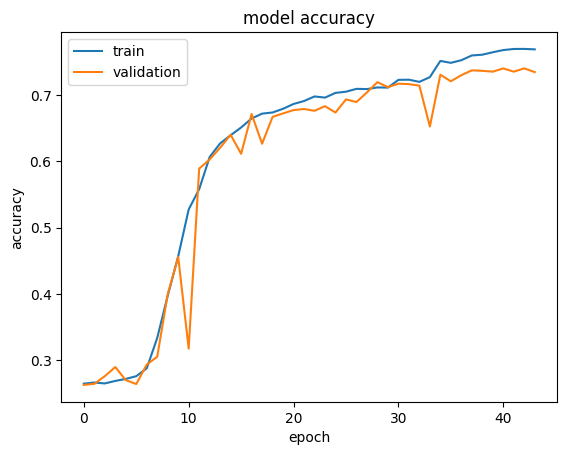

In [10]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [11]:
model9.evaluate(test_set)

78/78 [==============================] - 3s 32ms/step - loss: 0.5923 - accuracy: 0.7701


[0.5923373699188232, 0.770142674446106]

### **Plotting the confussion matrix**

78/78 [==============================] - 3s 31ms/step
Class 0 - F1_score: 0.8594, Precision: 0.9044, Recall: 0.8186
Class 1 - F1_score: 0.6914, Precision: 0.6414, Recall: 0.7500
Class 2 - F1_score: 0.6667, Precision: 0.6865, Recall: 0.6479
Class 3 - F1_score: 0.8480, Precision: 0.8321, Recall: 0.8645


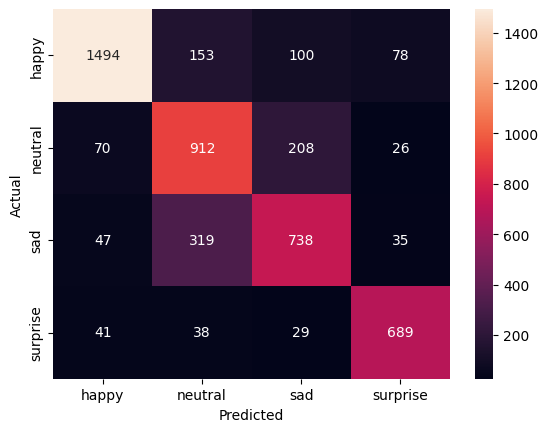

In [12]:
# Get predictions from the model for the test set
y_pred = model9.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The results on the test data yielded an accuracy of 0.77, with minimal overfitting observed. However, we still encountered the paradoxical situation where the accuracy on the test data was higher than that on the training and validation sets. Despite this, as this model is more complex than our best model, model3, it does not appear to enhance our performance.

## **Slightly simplified version of the last model**

We removed the last group of three conv layers with filters 512 and the first group of two conv layers with 32 filters to see if the performance increases. The model therefore contains:

- Two stacks of one Conv2D layer with 64 filters, kernel size (3x3), followed by Batch Normalization and RekyRelu activation
- A maxpooling layer of pool size (2x2) and stride (2x2).
- Dropout layer 25%.
- Two stacks of one Conv2D layer with 128 filters, kernel size (3x3),followed by Batch Normalization and RekyRelu activation
- A maxpooling layer of pool size (2x2) and stride (2x2).
- Dropout layer 30%.
- Three stacks of one Conv2D layer with 256 filters, kernel size (3x3) followed by Batch Normalization and RekyRelu activation
- Dropout layer of 40%
- Three stacks of one Conv2D layer with 512 filters, kernel size (3x3) followed by Batch Normalization and RekyRelu activation
- Dropout layer of50%
- A Global Avarage pooling layer trying to flatten the results.
- A 4 dense output layer with softmax activation.
- Adam optimizer with learning rate 0.0001 as the model was learning extremely fast with lower optimizers.
- Compiler with categorical crossentropy loss and Accuracy as metric.

In [13]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [14]:
# Initializing a sequential model
model10 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None, input_shape = (48, 48, 1)))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding second conv layer with 64 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model10.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 25%
model10.add(Dropout(0.25))

# Adding first conv layer with 128 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None ))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding second conv layer with 128 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = None ))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model10.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 30%
model10.add(Dropout(0.3))

# Adding first conv layer with 256 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding second conv layer with 256 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding third conv layer with 256 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model10.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 40%
model10.add(Dropout(0.4))

# Adding first conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding second conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding third conv layer with 512 filters and kernel size 3x3, padding 'same'
# provides the output size same as the input size, followed by Batch Normalization,
# with RekyReLU activation and the input_shape denotes input image dimension
model10.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'Same', activation = None))

model10.add(BatchNormalization())

model10.add(LeakyReLU())

# Adding max pooling to reduce the size of output of first conv layer
model10.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))

# Dropout 50%
model10.add(Dropout(0.5))

model10.add(GlobalAveragePooling2D())

# Adding the output layer with 4 neurons and activation functions as softmax since this is a multi-class classification problem
model10.add(Dense(4, activation = "softmax"))

# Using Adam Optimizer
opt = Adam(learning_rate = 0.001)

# Compile the model
model10.compile(optimizer = opt , loss = "categorical_crossentropy", metrics = ["accuracy"])

model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0

## **Compiling and training the model**


In [15]:
# The following lines of code saves the best model's parameters if training accuracy goes down on further training. They
# also stop the model if it doesn't learn after 5 epochs. On tope of it we included a callback that reduces the learning rate
# if its plateuing after 3 epochs. The objective of all this is to stop if the model is overfitting and help this overfit be
# by reducing the learning rate.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5, restore_best_weights = True)
mc = ModelCheckpoint('best_model10.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
rl = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# Fitting the model with 100 epochs with the callbacks defined above.
history=model10.fit(train_set,
          epochs = 100,
          validation_data = val_set,
          callbacks = [es, mc,rl])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 1.5213 - accuracy: 0.2669
Epoch 1: val_accuracy improved from -inf to 0.26349, saving model to best_model10.h5
191/191 [==============================] - 39s 156ms/step - loss: 1.5213 - accuracy: 0.2669 - val_loss: 1.3909 - val_accuracy: 0.2635 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 1.4144 - accuracy: 0.2923
Epoch 2: val_accuracy did not improve from 0.26349
191/191 [==============================] - 34s 176ms/step - loss: 1.4144 - accuracy: 0.2923 - val_loss: 1.4886 - val_accuracy: 0.2632 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 1.3945 - accuracy: 0.3051
Epoch 3: val_accuracy did not improve from 0.26349
191/191 [==============================] - 24s 127ms/step - loss: 1.3945 - accuracy: 0.3051 - val_loss: 1.6080 - val_accuracy: 0.2332 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - ETA: 0s - loss: 1.2911 - a

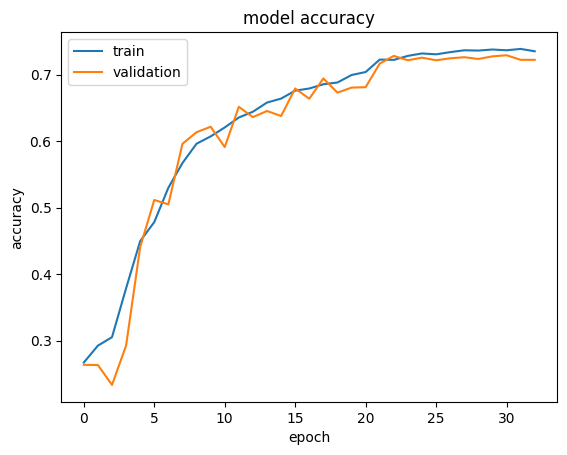

In [16]:
# Plotting the training and validation accuracies for each epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**


In [17]:
model10.evaluate(test_set)

78/78 [==============================] - 3s 42ms/step - loss: 0.6108 - accuracy: 0.7567


[0.6107834577560425, 0.7566807270050049]

### **Plotting the confussion matrix**


In [ ]:
# Get predictions from the model for the test set
y_pred = model10.predict(test_set)

# Get true labels
y_true = test_set.classes

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=np.argmax(y_pred, axis=1)).numpy()

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
class_names = list(test_set.class_indices.keys())

# Calculate accuracy, precision, and recall per class
num_classes = len(test_set.class_indices)
for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    tn = np.sum(cm) - tp - fn - fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'Class {i} - F1_score: {f1_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

**Observations:** The model arrived to Accuracy of 0.76 in the test set. The paradoxical result of finding higher accuracy in the test set than in training set is happening here, with the test accuracy been slightly bigger than the training accuracy. Again the model is more complex but doesn't arrive to a better level of accuracy than model3.

## **Conclusion:**
We have determined that model3 remains our best model. This model achieved an accuracy of 0.765, only slightly lower than the more complex architectures. We believe this model is superior due to its simplicity, which offers advantages in computational cost, and its minimal overfitting. The slightly higher accuracy in the test set compared to the training set can be attributed to the overrepresentation of the "happy" category in the test set. The model performed exceptionally well in this category, likely leading to the slightly higher accuracy in the test set compared to the training and validation sets. Therefore, it is likely that the minimal overfitting occurred when this phenomenon was observed.

78/78 [==============================] - 2s 21ms/step


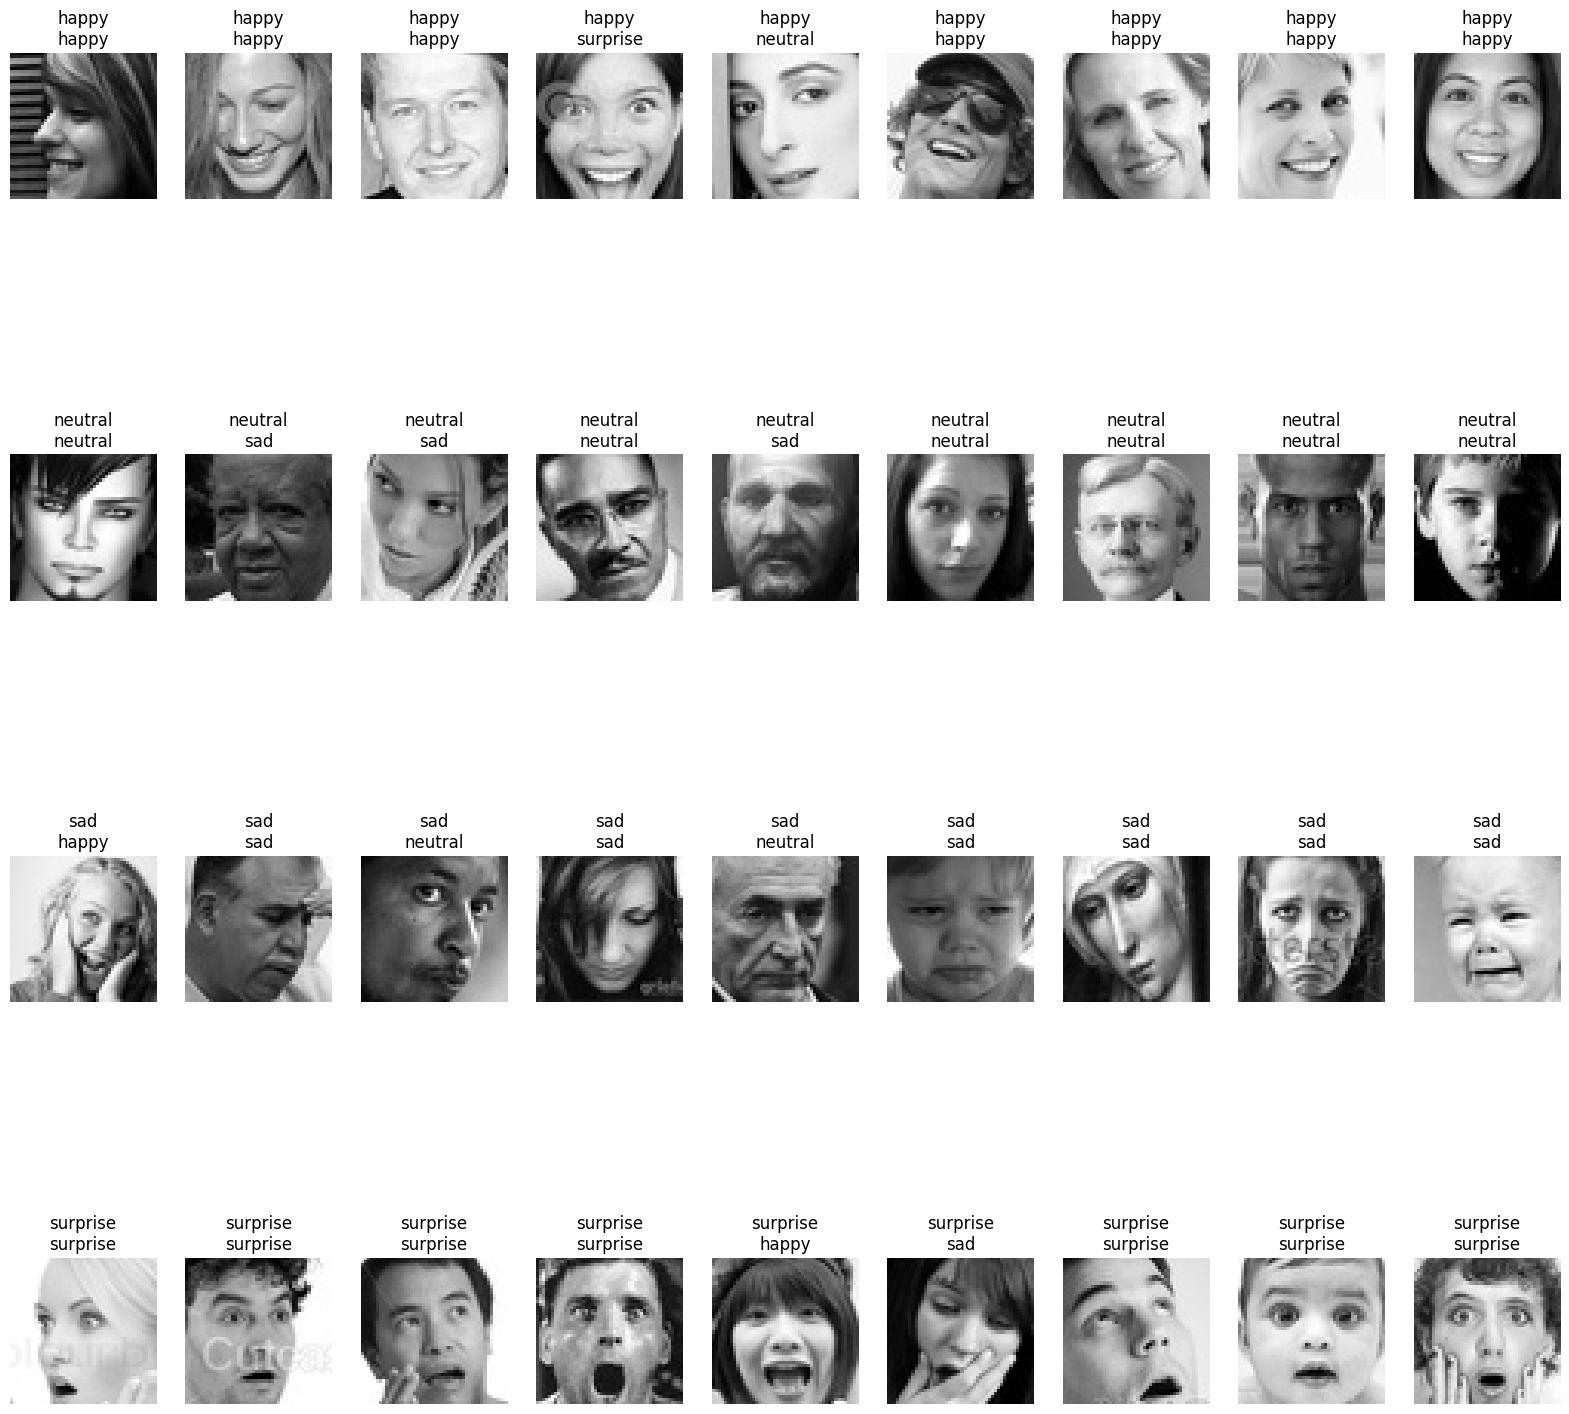

In [25]:
# Get the class labels
class_labels = list(test_set.class_indices.keys())

# Make predictions for all test set
num_samples = len(test_set.filenames)
num_steps = int(np.ceil(num_samples / test_set.batch_size))
predictions = model3.predict(test_set, steps=num_steps)

# Create a dictionary to store the images and predictions for each category
category_data = {label: {'images': [], 'predictions': []} for label in class_labels}

# Loop over the batches and store the images and predictions for each category
for i in range(num_steps):
    batch_images, batch_labels = test_set[i]
    batch_predictions = predictions[i*test_set.batch_size : (i+1)*test_set.batch_size]
    for j in range(test_set.batch_size):
        if i*test_set.batch_size + j >= num_samples:
            break
        label_idx = np.argmax(batch_labels[j])
        label = class_labels[label_idx]
        category_data[label]['images'].append(batch_images[j])
        category_data[label]['predictions'].append(batch_predictions[j])

# Plot 9 random images and predictions for each category in gray scale
fig, axs = plt.subplots(len(class_labels), 9, figsize=(20, 20))
for i, label in enumerate(class_labels):
    image_indices = np.random.choice(len(category_data[label]['images']), 9, replace=False)
    for j, idx in enumerate(image_indices):
        if idx < len(category_data[label]['images']):
            image = category_data[label]['images'][idx]
            prediction = category_data[label]['predictions'][idx]
            axs[i, j].imshow(image, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{label}\n{class_labels[np.argmax(prediction)]}')

plt.show()

**Observations:** As anticipated during the initial data inspection, the model encounters difficulties in distinguishing certain images that appear sad and resemble those categorized as neutral. Upon examining randomly selected photos, all images in the neutral category were correctly labeled except for one, which was misclassified as happy. Conversely, in the happy category, two misclassifications occurred: one due to a photo depicting an open mouth, which the model mistakenly categorized as surprised, and another possibly due to a mislabeled image (likely intended to be neutral) that the model categorized as neutral. The only misclassification in the surprised category occurred with a photo that bears more resemblance to a sad or neutral expression than a surprised one.

# **Executive Summary:**
We have found that transfer models were ineffective for our problem, even when some of the layers were retrained. This is understandable as these models have been trained on ImageNet, which contains images in color and with a higher resolution than our grayscale, lower-resolution images. Despite testing a variety of different models with varying complexities, the models with deep architectures did not outperform our relatively simple Model 3.

Model 3 achieved an accuracy of 0.77, with the best recognition rates for happy and surprise emotions at F1 scores of 0.84 and 0.86, respectively, and lower recognition rates for sad and neutral emotions at F1 scores of 0.68 and 0.64, respectively. Based on our analysis, we propose the following specifications for the final model architecture:

- Three layers with 64 filters each, followed by Batch Normalization and ReLU activation. After this stack of three layers, a max pool of size 3x3 and strides 3x3 is applied, followed by a Dropout of 25%.

- Three layers with 96 filters each, followed by Batch Normalization and ReLU activation. After this stack of three layers, a max pool of size 3x3 and strides 3x3 is applied, followed by a Dropout of 40%.

- Three layers with 128 filters each, followed by Batch Normalization and ReLU activation. After this stack of three layers, a max pool of size 3x3 and strides 3x3 is applied, followed by a Dropout of 50%.

- Finally, a Dense layer with 4 units and softmax activation is used for classification, along with categorical cross-entropy loss and an Adam optimizer with an initial learning rate of 0.001.

To further combat overfitting, we included callbacks that stop the model after 5 epochs of no improvement in the validation set's performance and reduce the learning rate by 0.2 after three epochs of no improvement.


# **Problem and Solution Summary:**

Facial emotional recognition is a critical technology with widespread applications in healthcare, marketing, and entertainment. However, accurately recognizing emotions from facial images poses significant challenges due to variations in lighting, pose, and facial expressions. To address this challenge, our proposed solution leverages a convolutional neural network (CNN), capable of learning complex features from raw image data, and a softmax activation function, which outputs probabilities of different emotions.

The model is trained on a large dataset of labeled facial images encompassing a diverse range of emotions. To enhance robustness, we employ data augmentation techniques such as rotation, zoom, brightness adjustments, and shear range variations during validation.

Despite our efforts, a key challenge remains in effectively differentiating between neutral and sad emotions. In certain scenarios, this limitation may pose challenges, as our model struggles to achieve an F1 score above 0.65 for these emotions. This issue warrants further investigation and refinement of our model to enhance its performance in accurately distinguishing between neutral and sad emotional states.

# **Recommendations for Implementation:**
To implement the proposed solution, stakeholders should take the following key actionables:

- Collect a large and diverse dataset of labeled facial images with a focus on including a variety of emotions, lighting conditions, poses, and facial expressions. Probably the model should be retrained on a data set that includes color images and not the gray scale ones included in this data set.

- Retrain the convolutional neural network model on the collected dataset and validate it using data augmentation techniques to increase the robustness of the model.

- Deploy the model in a cloud-based service for real-time facial emotional recognition, which can improve the efficiency of the recognition process and enable more personalized applications.

The expected benefits of the solution include improved accuracy and efficiency of facial emotional recognition, which can lead to better understanding of human emotions and more personalized applications. For example, healthcare providers can use the technology to monitor patients' emotional states, marketers can use it to tailor their campaigns to specific emotions, remote based education service can use it to measure engagement with the class and entertainment providers can use it to enhance user experiences.

The costs associated with the solution may include data collection and labeling, model training and validation, and deployment and maintenance of the cloud-based service. Assuming a target accuracy of 0.85, the benefits of the solution may include increased user satisfaction, higher engagement, and improved business performance. The costs may vary depending on the scale and complexity of the project, and will depend on the interest and resources of the bussiness. a simple solution such as the one employed here which arrived to a 0.77 accuracy may be anough for more bussiness but in case their is more resoures avialable, collecting a larger data set to increase the results to an accuracy around 0.85 may be advisable.

Potential risks or challenges of the proposed solution design may include privacy and security concerns, ethical considerations, and legal compliance issues, which need to be addressed through proper measures such as data anonymization, consent procedures, and regulatory compliance. Additionally, the model's performance may be affected by factors such as cultural differences in facial expressions, and the model may not generalize well to different datasets or applications. To further improve the accuracy of emotion recognition, it may be useful to analyze the misclassified images and identify any patterns or common characteristics that are causing the misclassification. For example, it may be helpful to examine the lighting conditions, facial expressions, or pose of the subjects in the images. Another approach that could be explored is transfer learning. While the current model did not perform well with pre-trained models, using coulour images with a higher resolution could improve the accuracy of emotion recognition.